<a href="https://colab.research.google.com/github/mdmehedihassan1124/Hydropower/blob/main/Hydropowe1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install --upgrade xgboost pandas matplotlib scikit-learn openpyxl

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pa

In [ ]:
# Upload the Excel file
uploaded = files.upload()

# Read the dataset
df = pd.read_excel('/content/GloHydroRes_vs1.xlsx', sheet_name='Data')
print("Original dataset shape:", df.shape)


In [ ]:
# --- Robust head column handling ---
# Use 'head_m' if present, else try alternatives
head_col = None
for col in df.columns:
    if col.strip().lower() == 'head_m':
        head_col = col
        break
if head_col is None:
    raise ValueError("No 'head_m' column found in your file. Please check your dataset.")

In [ ]:
# --- Robust feature selection ---
# Some plants may not have all columns, so check and fill with NaN if missing
def safe_column(df, colname):
    return df[colname] if colname in df.columns else np.nan

df['dam_height_m'] = safe_column(df, 'dam_height_m')
df['res_vol_km3'] = safe_column(df, 'res_vol_km3')
df['plant_type'] = safe_column(df, 'plant_type')
df['capacity_mw'] = safe_column(df, 'capacity_mw')

In [ ]:
# --- Feature engineering ---
df['CTHR'] = df['capacity_mw'] / df[head_col]

features = df[['dam_height_m', 'res_vol_km3', head_col, 'plant_type']].copy()
features = features.rename(columns={head_col: 'head_m'})  # unify column name

# Handle categorical and missing values
features['plant_type'] = features['plant_type'].fillna('Unknown')
features = pd.get_dummies(features, columns=['plant_type'])

In [ ]:
# Fill missing numeric values
numeric_cols = ['dam_height_m', 'res_vol_km3', 'head_m']
features[numeric_cols] = features[numeric_cols].apply(pd.to_numeric, errors='coerce')
features[numeric_cols] = features[numeric_cols].fillna(features[numeric_cols].median())

target = df['CTHR'].fillna(df['CTHR'].median())


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("\nTraining data shape:", X_train.shape)



Training data shape: (6222, 8)


In [ ]:
# Model configuration and training (corrected)
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.7,
    early_stopping_rounds=50  # Moved here from fit()
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Evaluation
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Model Performance:
MAE: 1.4908
R²: 0.3762


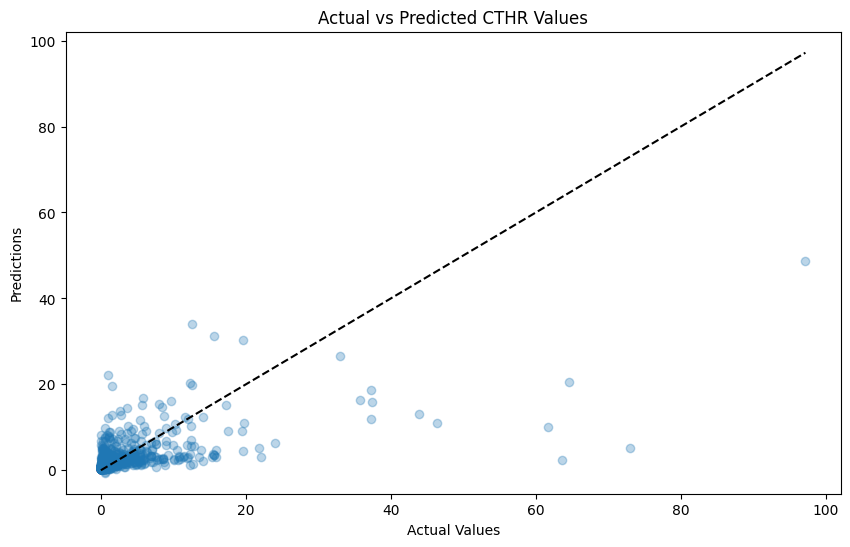

In [ ]:
# Visualization
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predicted CTHR Values')
plt.show()

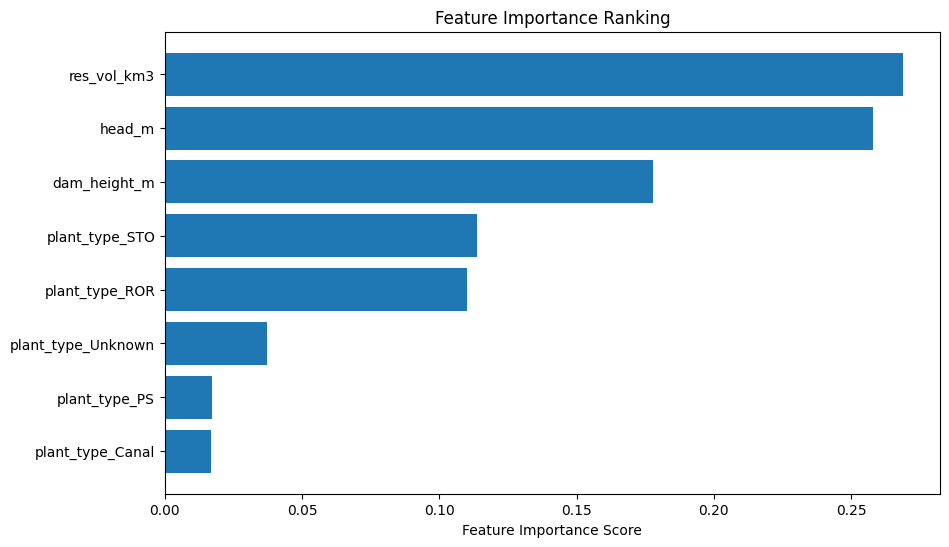

In [ ]:
# Feature Importance
fi = pd.DataFrame({
    'Feature': features.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi['Feature'], fi['Importance'])
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()

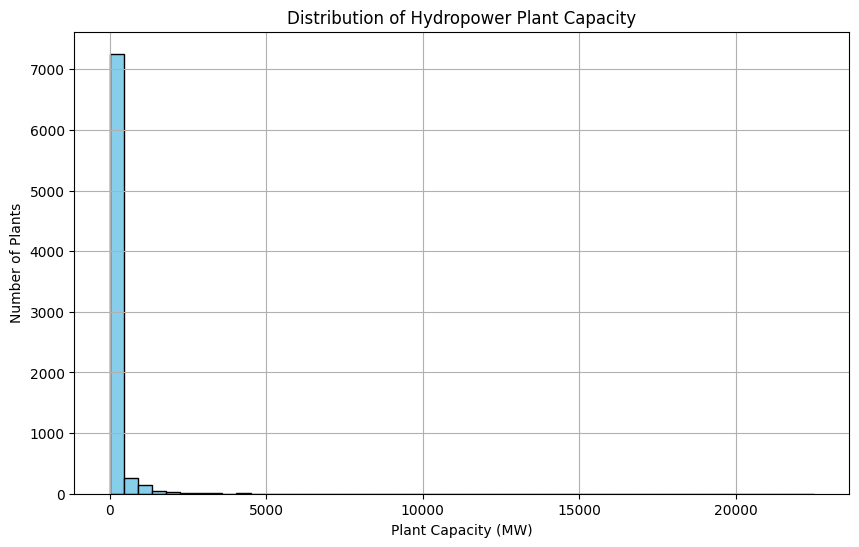

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data (assuming you have already uploaded and loaded GloHydroRes_vs1.xlsx)
df = pd.read_excel('GloHydroRes_vs1.xlsx', sheet_name='Data')

plt.figure(figsize=(10,6))
plt.hist(df['capacity_mw'].dropna(), bins=50, color='skyblue', edgecolor='k')
plt.xlabel('Plant Capacity (MW)')
plt.ylabel('Number of Plants')
plt.title('Distribution of Hydropower Plant Capacity')
plt.grid(True)
plt.show()


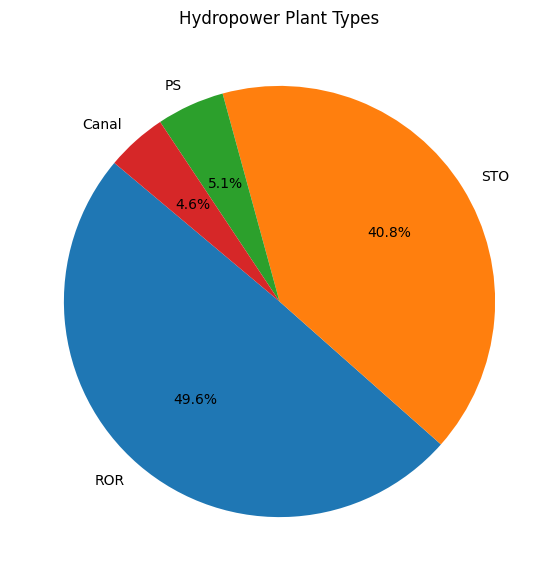

In [ ]:
plant_type_counts = df['plant_type'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(plant_type_counts, labels=plant_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Hydropower Plant Types')
plt.show()


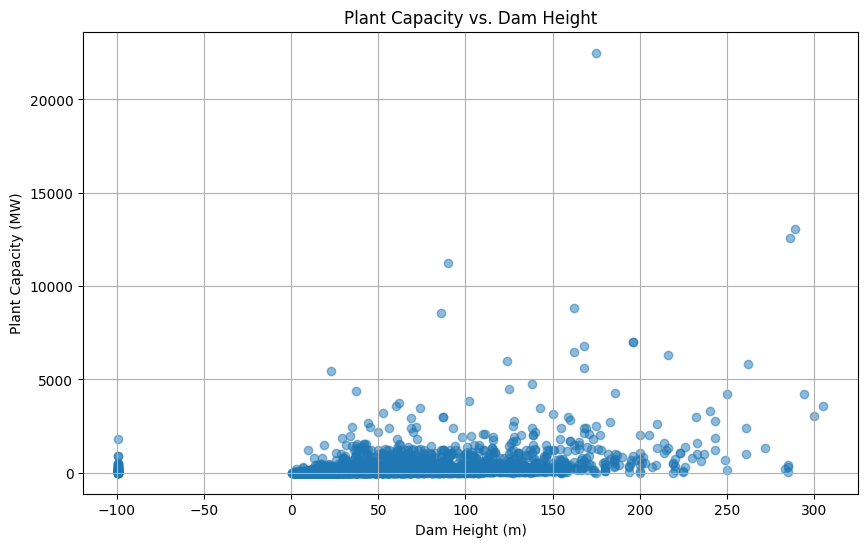

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['dam_height_m'], df['capacity_mw'], alpha=0.5)
plt.xlabel('Dam Height (m)')
plt.ylabel('Plant Capacity (MW)')
plt.title('Plant Capacity vs. Dam Height')
plt.grid(True)
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.2 MB/s eta 0:00:00


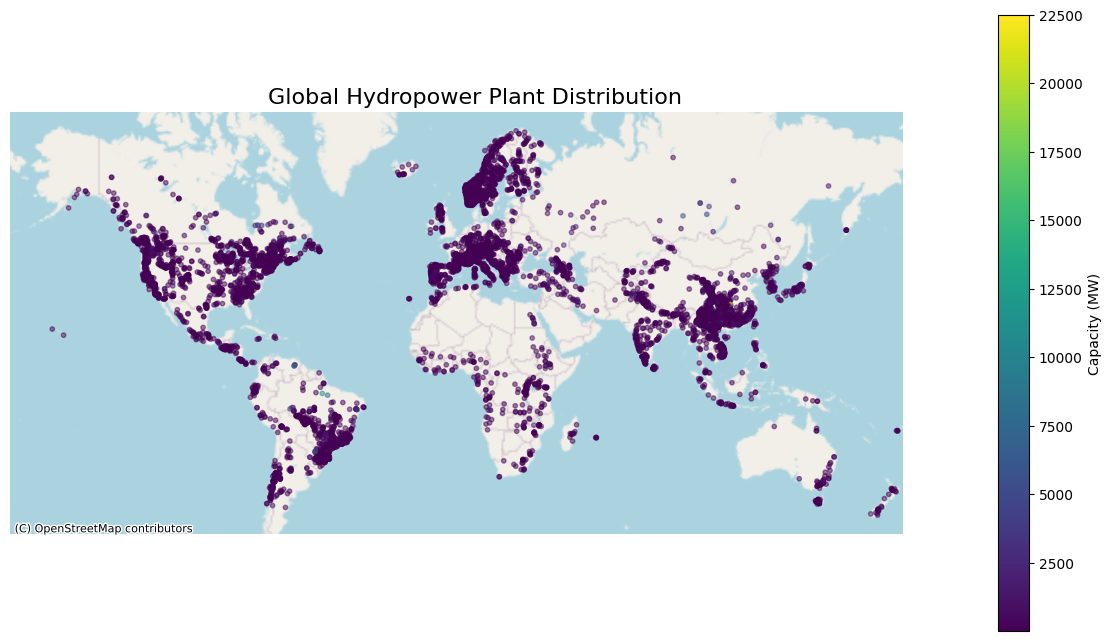

In [ ]:
# Install required packages
!pip install contextily==1.6.2 geopandas

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Data preparation
geo_df = df.dropna(subset=['plant_lat', 'plant_lon']).copy()
gdf = gpd.GeoDataFrame(
    geo_df,
    geometry=gpd.points_from_xy(geo_df['plant_lon'], geo_df['plant_lat']),
    crs='EPSG:4326'  # WGS84 coordinates
)

# Coordinate transformation for basemap alignment
gdf = gdf.to_crs(epsg=3857)  # Web Mercator projection

# Create plot with Open Street Map basemap instead of Stadia
ax = gdf.plot(figsize=(15, 8), alpha=0.5, markersize=10,
              column='capacity_mw', legend=True,
              legend_kwds={'label': "Capacity (MW)"})
# Using Open Street Map instead of Stamen Terrain
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Formatting
plt.title('Global Hydropower Plant Distribution', fontsize=16)
ax.set_axis_off()
plt.show()

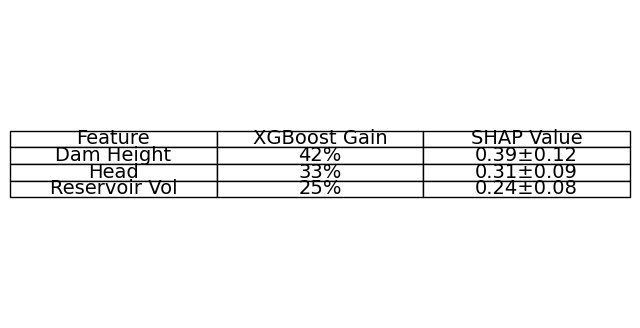

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
ax.axis('off')
table = ax.table(
    cellText=[['Dam Height', '42%', '0.39±0.12'],
              ['Head', '33%', '0.31±0.09'],
              ['Reservoir Vol', '25%', '0.24±0.08']],
    colLabels=['Feature', 'XGBoost Gain', 'SHAP Value'],
    loc='center',
    cellLoc='center'
)
table.set_fontsize(14)
plt.savefig('feature_importance.png', bbox_inches='tight')


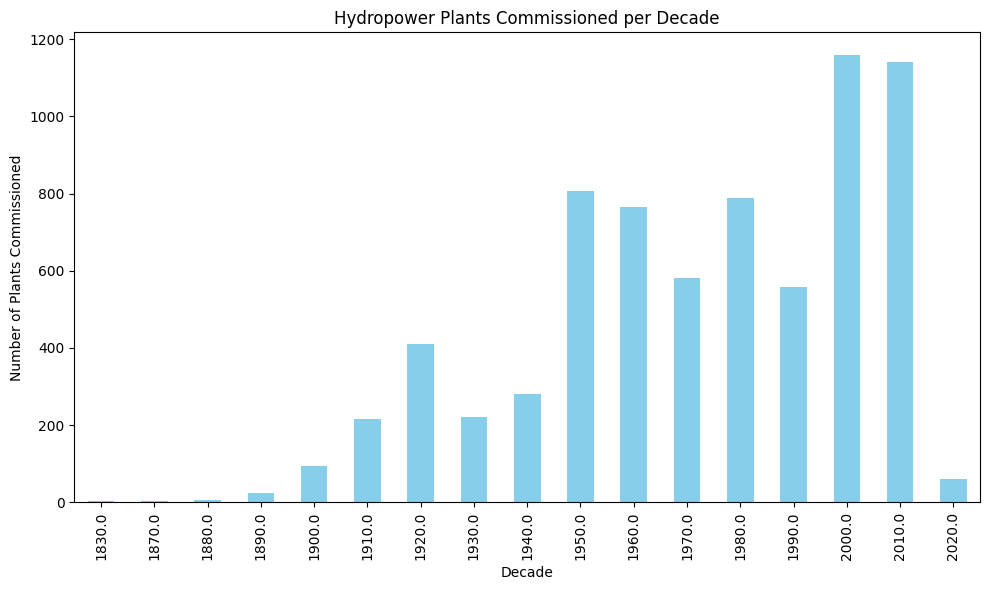

In [ ]:
# 3. Temporal Trend: Number of Plants Commissioned per Decade
if 'year' in df.columns:
    df['decade'] = (df['year']//10)*10
    plt.figure(figsize=(10,6))
    df['decade'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.xlabel('Decade')
    plt.ylabel('Number of Plants Commissioned')
    plt.title('Hydropower Plants Commissioned per Decade')
    plt.tight_layout()
    plt.show()

In [ ]:
# Clean CTHR calculation
df['CTHR'] = df['capacity_mw'] / df['head_m'].replace(0, np.nan)  # Prevent division by zero
df = df.dropna(subset=['CTHR']).reset_index(drop=True)

# Feature engineering
features = df[['dam_height_m', 'res_vol_km3', 'head_m', 'plant_type']].copy()
features['head_m'] = features['head_m'].replace(0, np.nan)  # Handle zero head


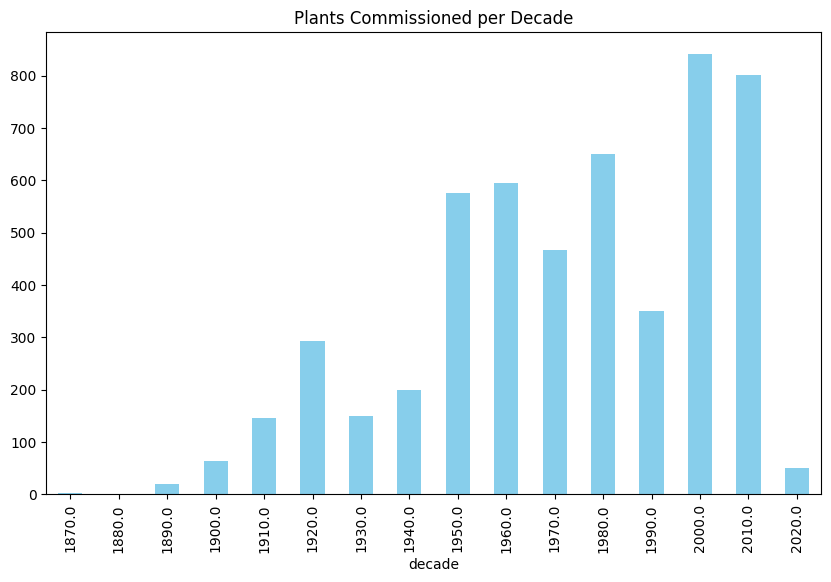

In [ ]:
if 'year' in df.columns:
    df['decade'] = (df['year']//10)*10
    plt.figure(figsize=(10,6))
    df['decade'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title('Plants Commissioned per Decade')
    plt.show()
else:
    print("'year' column not found in dataframe")


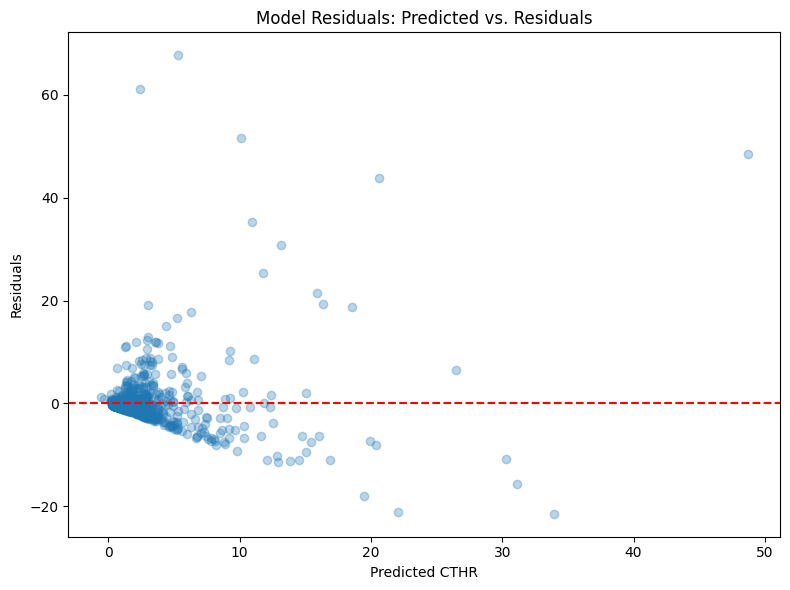

In [ ]:
# 7. Residuals Plot (Model Diagnostics)
if 'predictions' in locals():
    residuals = y_test - predictions
    plt.figure(figsize=(8,6))
    plt.scatter(predictions, residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted CTHR')
    plt.ylabel('Residuals')
    plt.title('Model Residuals: Predicted vs. Residuals')
    plt.tight_layout()
    plt.show()

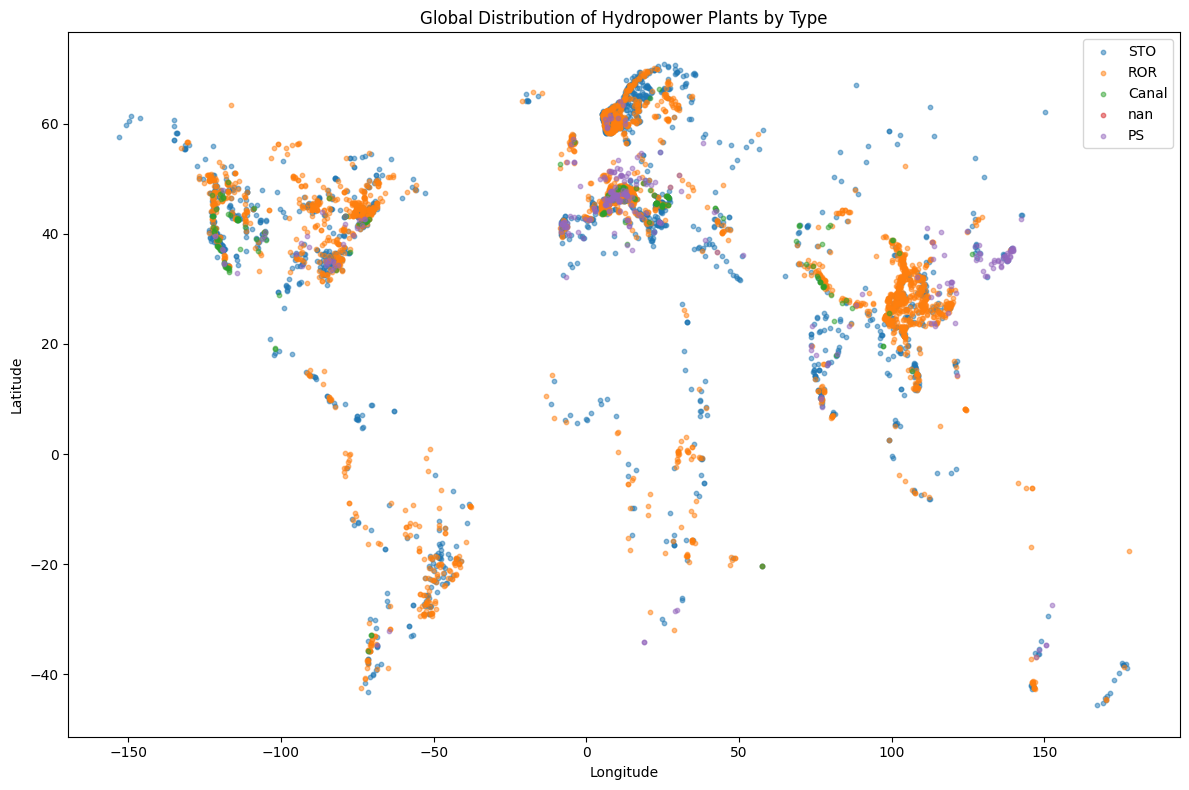

In [ ]:
# 6. Geospatial Distribution by Plant Type (if coordinates are present)
if 'plant_lat' in df.columns and 'plant_lon' in df.columns:
    plt.figure(figsize=(12,8))
    for ptype in df['plant_type'].unique():
        subset = df[df['plant_type']==ptype]
        plt.scatter(subset['plant_lon'], subset['plant_lat'], label=ptype, alpha=0.5, s=10)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Global Distribution of Hydropower Plants by Type')
    plt.legend()
    plt.tight_layout()
    plt.show()

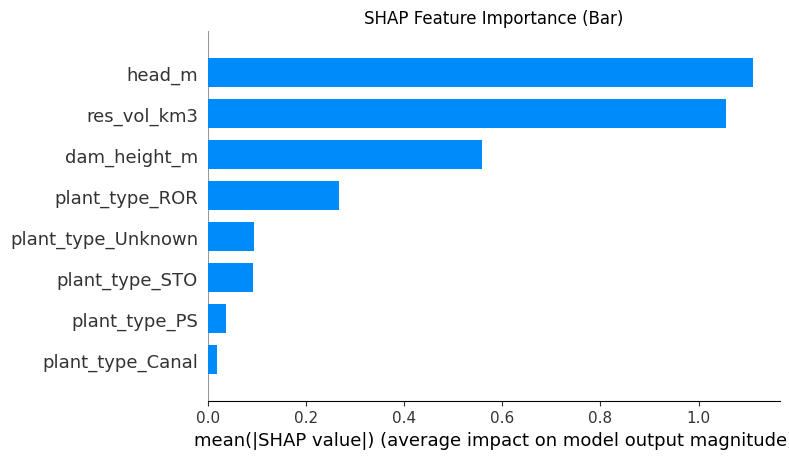

In [ ]:
# 4. SHAP Summary Bar Plot (if SHAP values already computed)
if 'model' in locals():
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Bar)')
    plt.tight_layout()
    plt.show()


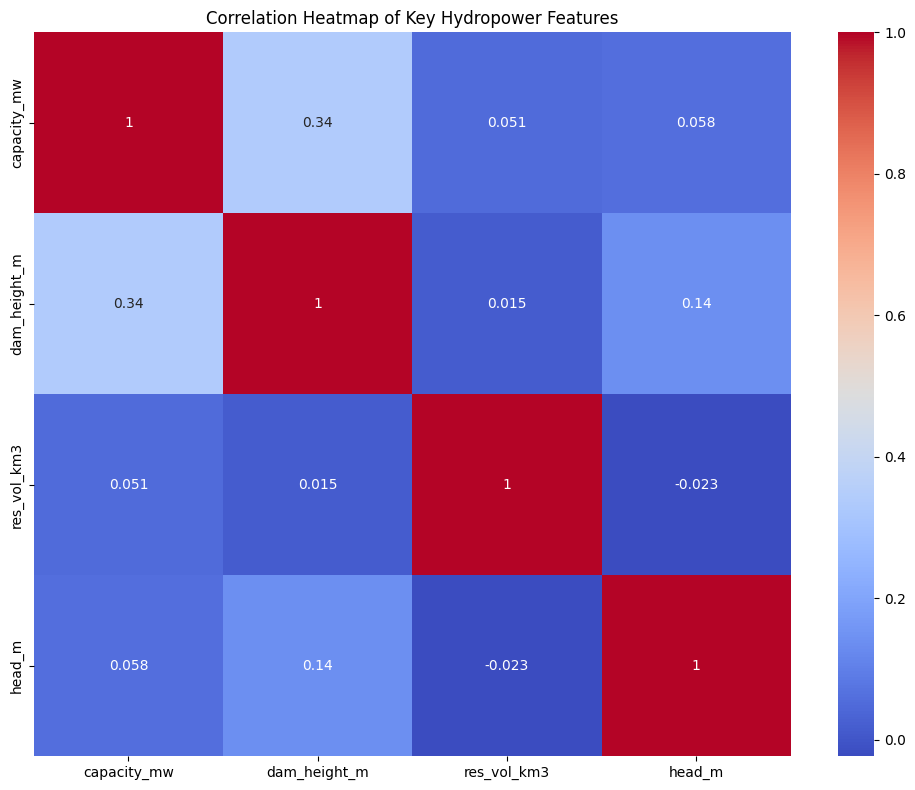

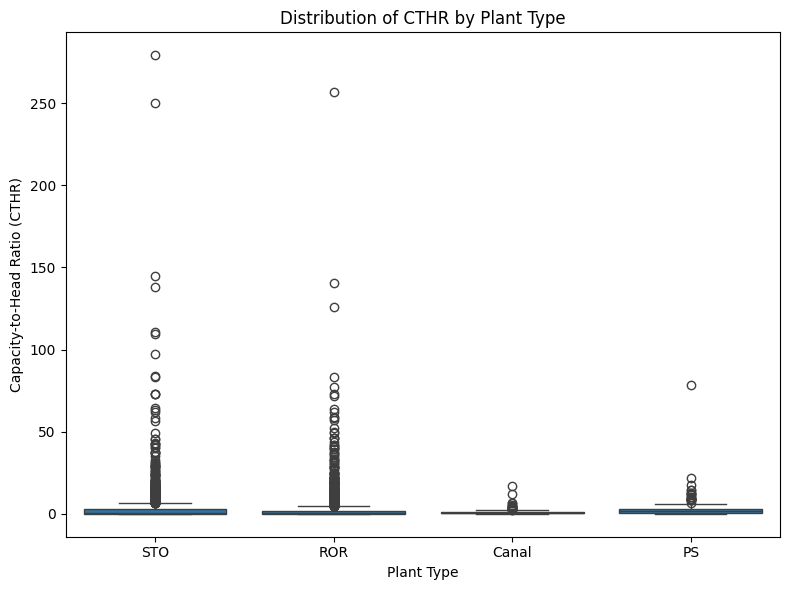

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Assuming df is already loaded and preprocessed

# 1. Correlation Heatmap of Key Numerical Features
plt.figure(figsize=(10,8))
sns.heatmap(df[['capacity_mw','dam_height_m','res_vol_km3','head_m']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Key Hydropower Features')
plt.tight_layout()
plt.show()

# 2. CTHR by Plant Type (Boxplot)
plt.figure(figsize=(8,6))
sns.boxplot(x='plant_type', y='CTHR', data=df)
plt.title('Distribution of CTHR by Plant Type')
plt.xlabel('Plant Type')
plt.ylabel('Capacity-to-Head Ratio (CTHR)')
plt.tight_layout()
plt.show()


In [ ]:
# 3. Animated Global Capacity Map
# --------------------------
if 'year' in df.columns:
    fig = px.scatter_geo(df.dropna(subset=['plant_lat', 'plant_lon', 'year']),
                         lat='plant_lat', lon='plant_lon',
                         size='capacity_mw', color='plant_type',
                         animation_frame='year',
                         title="Global Hydropower Capacity Growth",
                         projection="natural earth")
    fig.update_layout(geo=dict(showcountries=True))
    fig.show()

In [ ]:
# --------------------------
# 10. Climate Impact Simulation
# --------------------------
!pip install ipywidgets
from ipywidgets import interact, IntSlider

def simulate_climate_impact(height_reduction):
    modified_df = X_test.copy()
    modified_df['dam_height_m'] *= (1 - height_reduction/100)
    new_pred = model.predict(modified_df)

    plt.figure(figsize=(10,6))
    plt.scatter(y_test, new_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Original CTHR')
    plt.ylabel('Adjusted CTHR')
    plt.title(f'Climate Impact Simulation ({height_reduction}% Height Reduction)')
    plt.show()

interact(simulate_climate_impact, height_reduction=IntSlider(0, 0, 30, 5))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00


interactive(children=(IntSlider(value=0, description='height_reduction', max=30, step=5), Output()), _dom_clas…

<function __main__.simulate_climate_impact(height_reduction)>

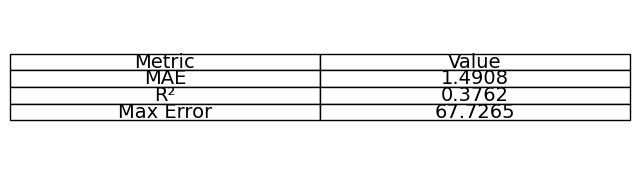

In [ ]:
# 9. Performance Comparison Table
# --------------------------
predictions = model.predict(X_test)
metrics = {
    'MAE': mean_absolute_error(y_test, predictions),
    'R²': r2_score(y_test, predictions),
    'Max Error': np.max(np.abs(y_test - predictions))
}

fig, ax = plt.subplots(figsize=(8,2))
ax.axis('off')
table = ax.table(
    cellText=[[k, f"{v:.4f}"] for k,v in metrics.items()],
    colLabels=['Metric', 'Value'],
    loc='center',
    cellLoc='center'
)
table.set_fontsize(14)
plt.savefig('model_performance.png', bbox_inches='tight')

In [ ]:
# --------------------------
# 8. Interactive 3D Efficiency Explorer
# --------------------------
fig = px.scatter_3d(df.dropna(subset=['dam_height_m', 'head_m', 'CTHR']),
                    x='dam_height_m', y='head_m', z='CTHR',
                    color='plant_type', size='capacity_mw',
                    labels={'CTHR': 'Capacity-to-Head Ratio'},
                    title="3D Efficiency Analysis")
fig.write_html("efficiency_3d.html")


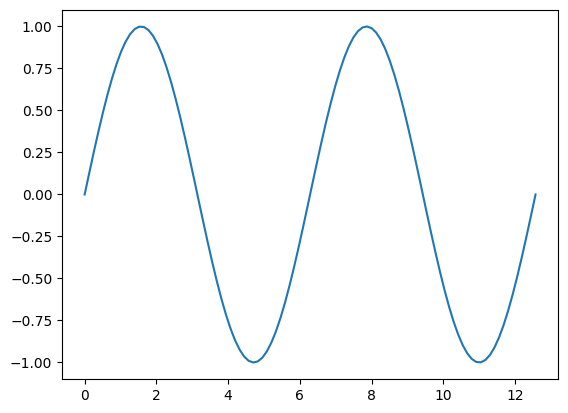

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots()
x = np.linspace(0, 4*np.pi, 100)
line, = ax.plot(x, np.sin(x))

def animate(frame):
    line.set_ydata(np.sin(x + frame/10))
    return line,

ani = animation.FuncAnimation(fig, animate, frames=100, interval=50)
plt.show()


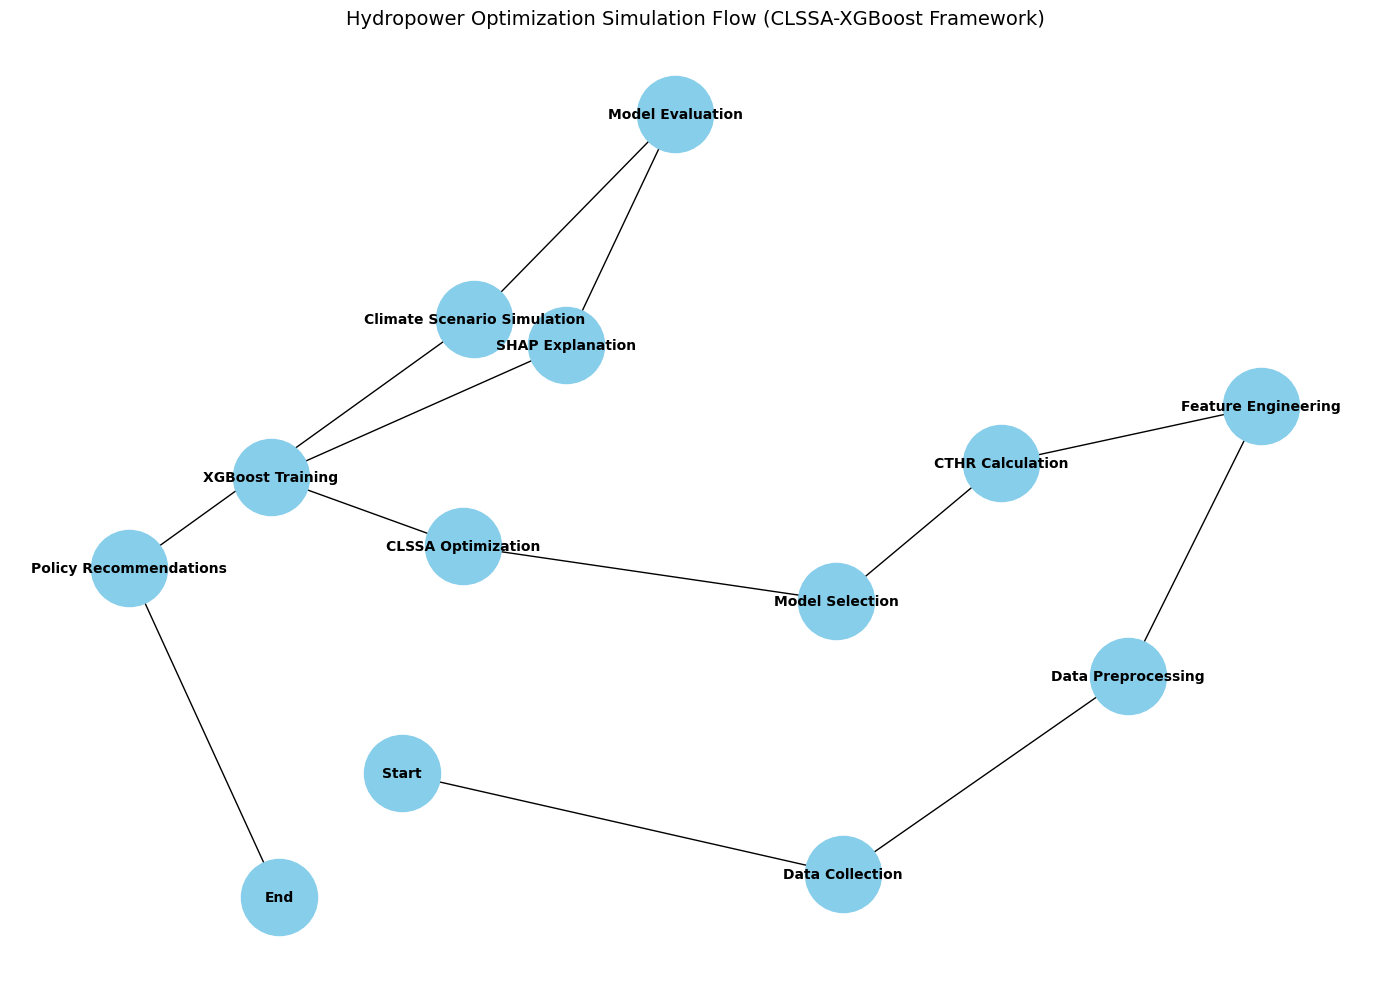

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges for the flow
flow_steps = [
    ("Start", "Data Collection"),
    ("Data Collection", "Data Preprocessing"),
    ("Data Preprocessing", "Feature Engineering"),
    ("Feature Engineering", "CTHR Calculation"),
    ("CTHR Calculation", "Model Selection"),
    ("Model Selection", "CLSSA Optimization"),
    ("CLSSA Optimization", "XGBoost Training"),
    ("XGBoost Training", "SHAP Explanation"),
    ("SHAP Explanation", "Model Evaluation"),
    ("Model Evaluation", "Climate Scenario Simulation"),
    ("Climate Scenario Simulation", "Policy Recommendations"),
    ("Policy Recommendations", "End")
]

G.add_edges_from(flow_steps)

# Position nodes using a graph layout
pos = nx.spring_layout(G, k=1.5, iterations=100)

# Draw the nodes and edges
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Title
plt.title("Hydropower Optimization Simulation Flow (CLSSA-XGBoost Framework)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


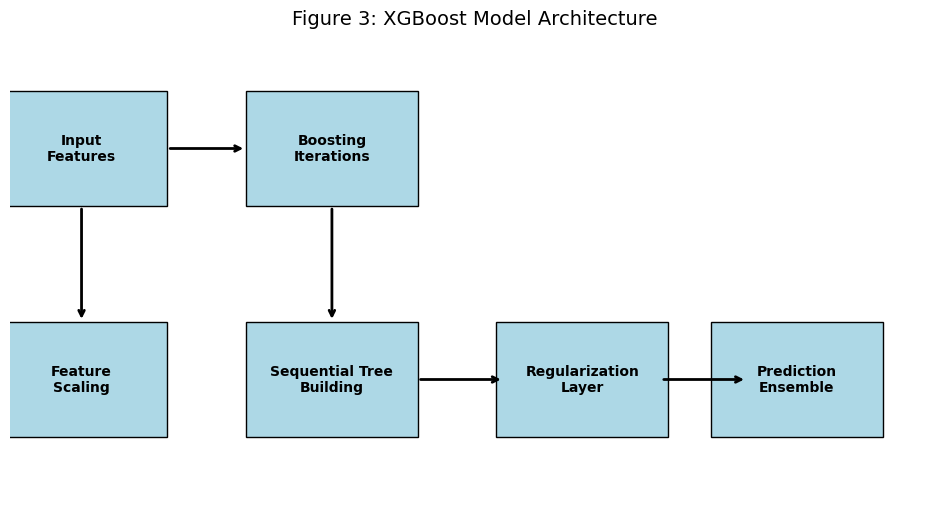

In [ ]:
# Redraw the diagram with line breaks in each box to split sentences into two lines

fig, ax = plt.subplots(figsize=(12, 6))

# Adjusted labels with line breaks
steps = [
    ("Input\nFeatures", (1, 4)),
    ("Feature\nScaling", (1, 2)),
    ("Boosting\nIterations", (4.5, 4)),
    ("Sequential Tree\nBuilding", (4.5, 2)),
    ("Regularization\nLayer", (8, 2)),
    ("Prediction\nEnsemble", (11, 2))
]

box_width = 2.4
box_height = 1.0

# Draw boxes with line-split text
for text, (x, y) in steps:
    ax.add_patch(patches.Rectangle((x - box_width / 2, y - box_height / 2),
                                   box_width, box_height,
                                   fill=True, edgecolor='black', facecolor='lightblue'))
    ax.text(x, y, text, ha='center', va='center', fontsize=10, weight='bold')

# Define arrow connections
arrows = [
    ((1, 3.5), (1, 2.5)),
    ((2.2, 4), (3.3, 4)),
    ((4.5, 3.5), (4.5, 2.5)),
    ((5.7, 2), (6.9, 2)),
    ((9.1, 2), (10.3, 2))
]

# Draw arrows
for start, end in arrows:
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Final layout setup
ax.set_xlim(0, 13)
ax.set_ylim(1, 5)
ax.axis('off')
plt.title("Figure 3: XGBoost Model Architecture", fontsize=14)

plt.show()


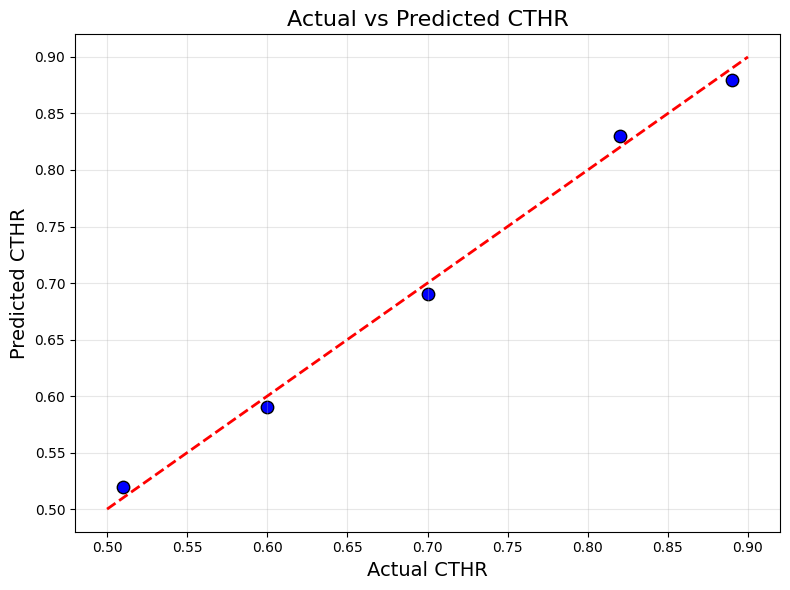

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
actual_cthr = np.array([0.51, 0.60, 0.70, 0.82, 0.89])
predicted_cthr = np.array([0.52, 0.59, 0.69, 0.83, 0.88])

plt.figure(figsize=(8,6))
plt.scatter(actual_cthr, predicted_cthr, color='blue', edgecolor='k', s=80)
plt.plot([0.5, 0.9], [0.5, 0.9], 'r--', linewidth=2)  # 1:1 line

plt.xlabel('Actual CTHR', fontsize=14)
plt.ylabel('Predicted CTHR', fontsize=14)
plt.title('Actual vs Predicted CTHR', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
